### 1. 패키지 설치 및 데이터 로드

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.svm as svm
from sklearn.svm import SVC
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [23]:
df = pd.read_excel('./Raisin_Dataset.xlsx')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [24]:
df['Class'].value_counts()

Class
Kecimen    450
Besni      450
Name: count, dtype: int64

### 2. EDA

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

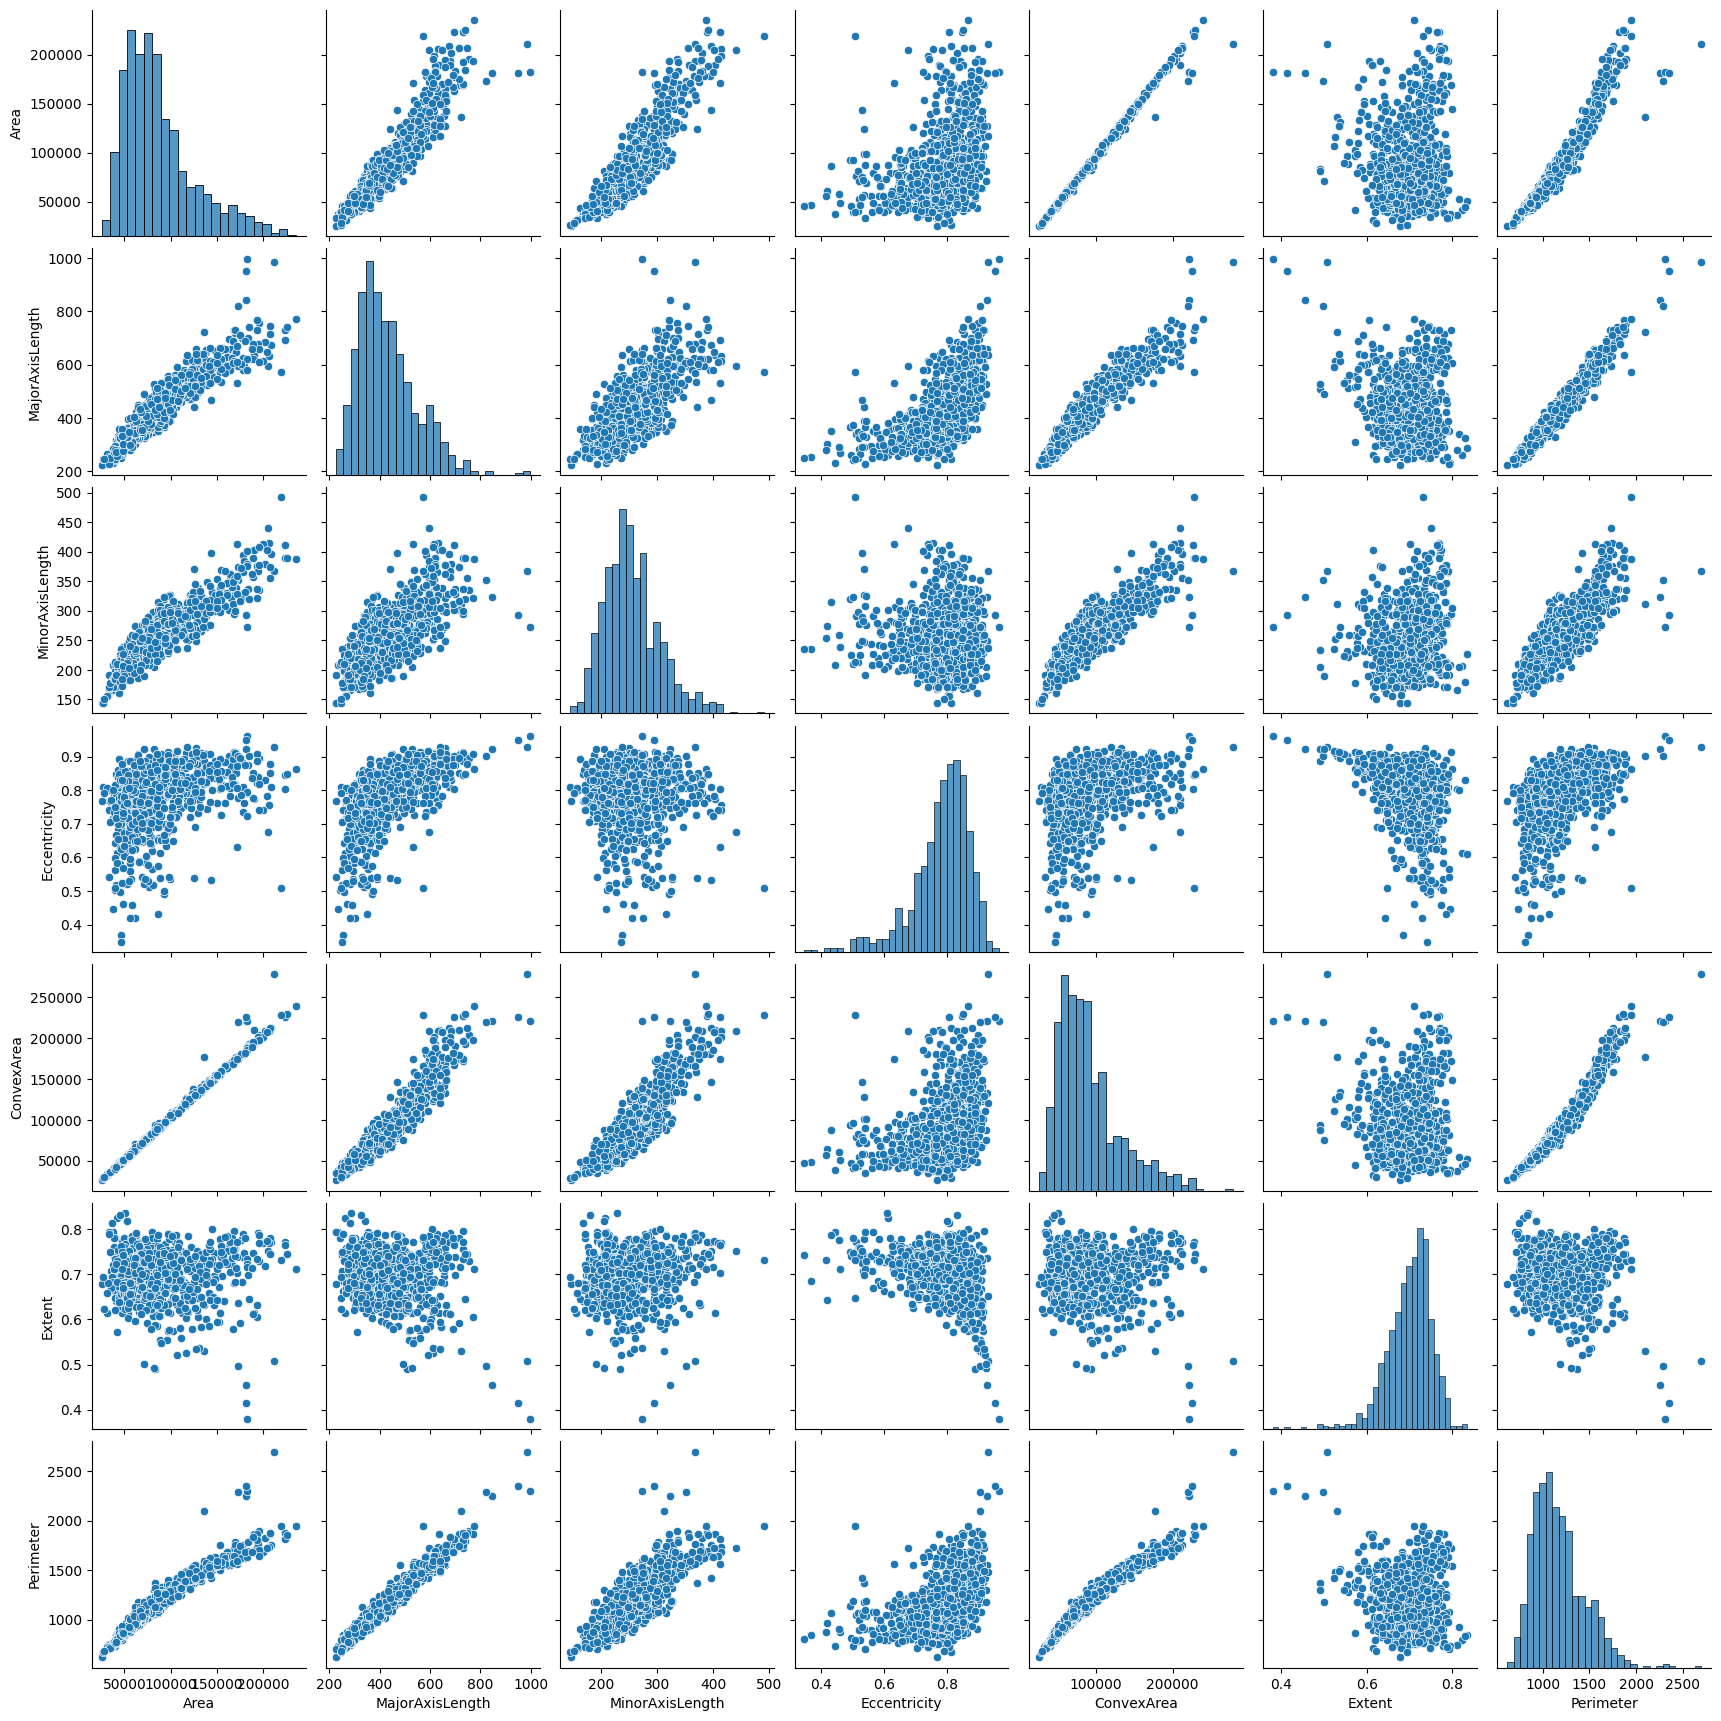

In [25]:
plt.figure(figsize=(20,20))
sb.pairplot(df)
plt.show()

> 선형관계를 많이 띄고 있군..

### 3. 독립변수와 종속변수 분리 및 데이터 정규화

In [26]:
# 독립변수
df_x = df.drop(['Area', 'Class'], axis=1)
df_y = df[['Class']]

# 데이터 정규화 (SVM은 거리를 기반으로 한 모델이기 떄문에)
MinMaxScaler = MinMaxScaler()
df_minmax = MinMaxScaler.fit_transform(df_x)

# 칼럼명 결합
df_x = pd.DataFrame(data=df_minmax, columns=df_x.columns)
df_x.head()

,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
0,0.280714,0.314376,0.767872,0.255504,0.831422,0.271791
1,0.234638,0.284945,0.738636,0.208864,0.667854,0.241842
2,0.280741,0.351778,0.733009,0.268084,0.565754,0.283594
3,0.078935,0.186620,0.548194,0.084089,0.701809,0.108284
4,0.164011,0.422064,0.350968,0.219472,0.906315,0.218493


### [궁금증] MinMaxScaler와 StandardScaler의 쓰임의 차이를 모르겠다...
#### MinMaxScaler:
- 데이터를 [0, 1] 범위로 스케일링합니다.
- 이상치(outlier)에 민감하지 않습니다.
- `주로 데이터의 분포가 정규분포가 아닌 경우에 사용`됩니다.
- 예를 들어, 이미지 픽셀 값, 데이터가 특정 범위 내에 제한되어 있는 경우 등에 사용될 수 있습니다.
- 최소-최대 스케일링은 `데이터의 절대적 크기를 유지해야 할 때 유용`합니다.

#### StandardScaler:
- 데이터를 평균이 0이고 표준편차가 1인 표준 정규 분포로 스케일링합니다.
- 이상치에 덜 민감합니다.
- `주로 데이터의 분포가 정규분포를 따를 때 사용`됩니다.
- 예를 들어, 선형 회귀, 로지스틱 회귀, 서포트 벡터 머신 등의 알고리즘에서 사용될 수 있습니다.

### 4. 데이터셋 분리

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.4, random_state=10)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(540, 6) (360, 6)
(540, 1) (360, 1)


> 관측치가 900개 밖에 되지 않기 때문에 6:4 비율로 분리

### 5. 선형SVM 모델링 (Kernel=linear)

In [28]:
svm = SVC(kernel='linear', degree=3, gamma='auto', C=10, max_iter=1000)
svm.fit(x_train, y_train)

print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))

0.8648148148148148
0.8638888888888889


c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> kernel : default=rbf (options = 'linear', 'poly', 'sigmoid', 'precomputed') <br>

> degree=3 : 3차항으로 설정<br>

> gamma : RBF kernel에서 사용되는 매개변수. `데이터 포인트가 영향을 미치는 범위를 조절`. 작은 gamma값은 모델을 보다 단순하게 만들고, 큰 gamma값은 보다 복잡한 모델을 만들게 된다. <br>

> C : `오차허용마진을 조절하는 매개변수`(for 소프트마진). C값이 클수록 오분류를 허용하지 않지만 과적합의 위험이 있으며, C값이 작을수록 오분류를 허용하며 과적합을 방지할 수 있고, 결정경계를 부드럽게 만든다. <br>


### 6. 비선형SVM 모델링 (Kernel='rbf')

In [29]:
# 매개변수 C는 오차허용 정도를 조절하는 매개변수!!
# -> rbf SVM C값 1~30별 모델 성능 확인해보자!!

scores = []
for C_point in [*range(1,31)]:
    svm = SVC(kernel='rbf', degree=3, C=C_point, gamma='auto', max_iter=1000)
    C_model = svm.fit(x_train, y_train)
    train_score = C_model.score(x_train, y_train)
    test_score = C_model.score(x_test, y_test)
    print("rbf SVM : C:{}, train set score:{:2f}, test set score:{:2f}".format(C_point, train_score, test_score))
    scores.append([train_score, test_score])

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validatio

rbf SVM : C:1, train set score:0.859259, test set score:0.872222
rbf SVM : C:2, train set score:0.862963, test set score:0.875000
rbf SVM : C:3, train set score:0.861111, test set score:0.863889
rbf SVM : C:4, train set score:0.862963, test set score:0.866667
rbf SVM : C:5, train set score:0.862963, test set score:0.863889
rbf SVM : C:6, train set score:0.862963, test set score:0.863889
rbf SVM : C:7, train set score:0.861111, test set score:0.866667
rbf SVM : C:8, train set score:0.859259, test set score:0.863889
rbf SVM : C:9, train set score:0.859259, test set score:0.863889
rbf SVM : C:10, train set score:0.859259, test set score:0.863889


c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validatio

rbf SVM : C:11, train set score:0.861111, test set score:0.863889
rbf SVM : C:12, train set score:0.862963, test set score:0.866667
rbf SVM : C:13, train set score:0.861111, test set score:0.866667
rbf SVM : C:14, train set score:0.862963, test set score:0.866667
rbf SVM : C:15, train set score:0.862963, test set score:0.866667
rbf SVM : C:16, train set score:0.862963, test set score:0.866667
rbf SVM : C:17, train set score:0.862963, test set score:0.863889
rbf SVM : C:18, train set score:0.862963, test set score:0.863889
rbf SVM : C:19, train set score:0.862963, test set score:0.863889
rbf SVM : C:20, train set score:0.862963, test set score:0.863889
rbf SVM : C:21, train set score:0.862963, test set score:0.866667
rbf SVM : C:22, train set score:0.862963, test set score:0.866667
rbf SVM : C:23, train set score:0.862963, test set score:0.869444
rbf SVM : C:24, train set score:0.862963, test set score:0.869444
rbf SVM : C:25, train set score:0.862963, test set score:0.875000
rbf SVM : 

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validatio

In [30]:
scores

[[0.8592592592592593, 0.8722222222222222],
 [0.8629629629629629, 0.875],
 [0.8611111111111112, 0.8638888888888889],
 [0.8629629629629629, 0.8666666666666667],
 [0.8629629629629629, 0.8638888888888889],
 [0.8629629629629629, 0.8638888888888889],
 [0.8611111111111112, 0.8666666666666667],
 [0.8592592592592593, 0.8638888888888889],
 [0.8592592592592593, 0.8638888888888889],
 [0.8592592592592593, 0.8638888888888889],
 [0.8611111111111112, 0.8638888888888889],
 [0.8629629629629629, 0.8666666666666667],
 [0.8611111111111112, 0.8666666666666667],
 [0.8629629629629629, 0.8666666666666667],
 [0.8629629629629629, 0.8666666666666667],
 [0.8629629629629629, 0.8666666666666667],
 [0.8629629629629629, 0.8638888888888889],
 [0.8629629629629629, 0.8638888888888889],
 [0.8629629629629629, 0.8638888888888889],
 [0.8629629629629629, 0.8638888888888889],
 [0.8629629629629629, 0.8666666666666667],
 [0.8629629629629629, 0.8666666666666667],
 [0.8629629629629629, 0.8694444444444445],
 [0.8629629629629629, 0.

In [31]:
len(scores)

30

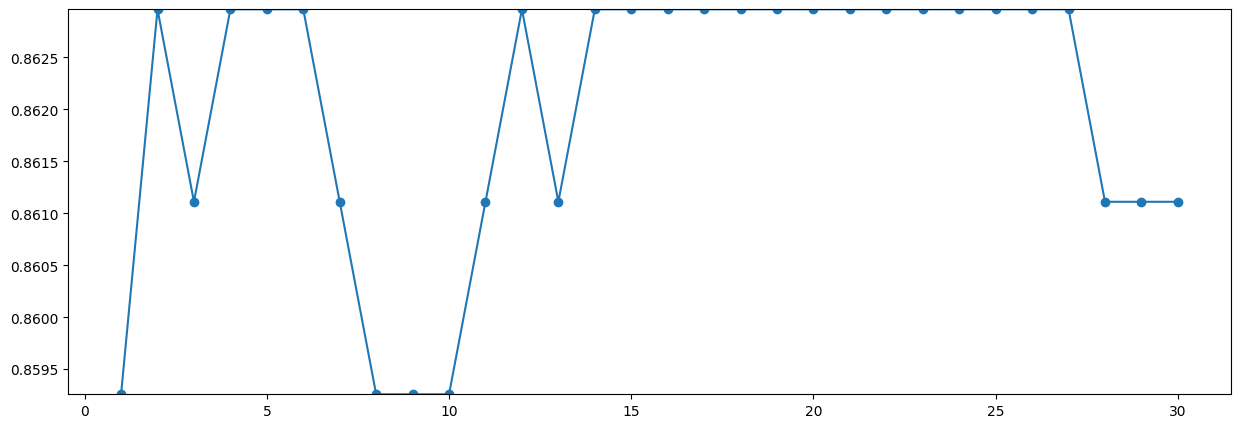

In [34]:
# C값에 따른 train_score 시각화
train_score_data = [elem[0] for elem in scores]

# 플롯 생성
plt.figure(figsize=(15,5))
x_values = [*range(1,len(train_score_data)+1)]
plt.plot(x_values, train_score_data, marker='o')

# y축의 하위 및 상위 범위 설정
plt.ylim(min(train_score_data), max(train_score_data))

# 플롯 표시
plt.show()


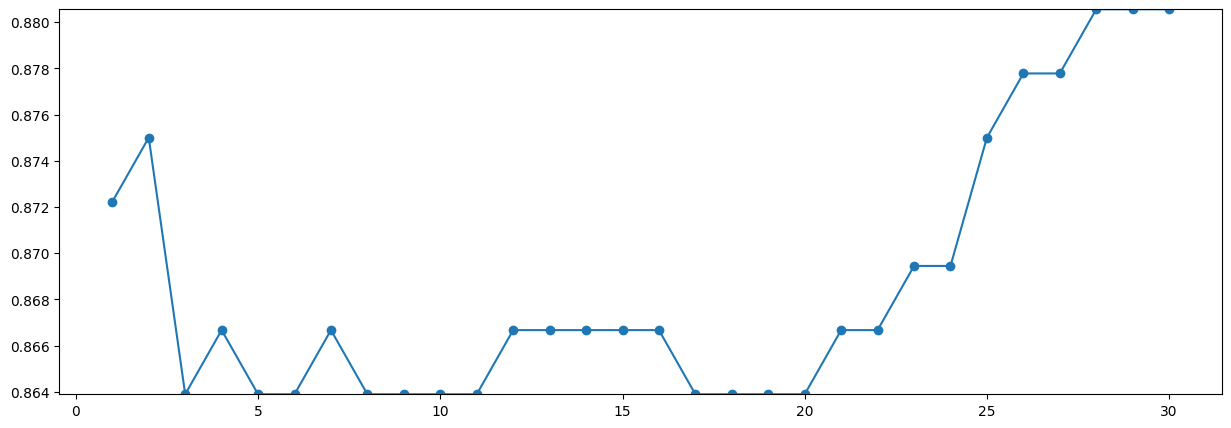

In [35]:
# C값에 따른 test_score 시각화
test_score_data = [elem[1] for elem in scores]

# 플롯 생성
plt.figure(figsize=(15,5))
x_values = [*range(1,len(test_score_data)+1)]
plt.plot(x_values, test_score_data, marker='o')

# y축의 하위 및 상위 범위 설정
plt.ylim(min(test_score_data), max(test_score_data))

# 플롯 표시
plt.show()

In [12]:
# gamma는 모델의 복잡도를 설정하는 매개변수!! (어쩌면 C와 반대되는 개념)
# rbf SVM gamma값 1~30에 따른 모델 성능 확인해보자!!

scores = []
for gamma_point in [0.1, 0.5, 1, 5, 10, 20]:
    svm = SVC(kernel='rbf', degree=3, C=10, gamma=gamma_point,max_iter=1000)
    gamma_model = svm.fit(x_train, y_train)
    train_score = gamma_model.score(x_train, y_train)
    test_score = gamma_model.score(x_test, y_test)
    print("rbf SVM : gamma:{}, train set score:{:2f}, test set score:{:2f}".format(gamma_point, train_score, test_score))
    scores.append([train_score, test_score])

rbf SVM : gamma:0.1, train set score:0.862963, test set score:0.866667


rbf SVM : gamma:0.5, train set score:0.864815, test set score:0.880556
rbf SVM : gamma:1, train set score:0.861111, test set score:0.877778
rbf SVM : gamma:5, train set score:0.862963, test set score:0.880556
rbf SVM : gamma:10, train set score:0.864815, test set score:0.883333
rbf SVM : gamma:20, train set score:0.879630, test set score:0.872222


c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validatio

**********